In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from scipy import ndimage as nd

import time
import torch.nn.functional as F

# Basic image processing

In [7]:
bears = cv2.imread('bears.jpg')

In [17]:
# read image by cv2 -> Bgr -> RGB 
# """""" to create docstring
def preprocess_image(image: np.ndarray)->np.ndarray:
    """
    Args: image: input image to be preprocessed
    return: out: preprocessed image
    """
    out = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    out =  out / 255.0
    return out

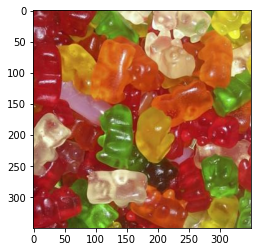

In [22]:
plt.figure(0)
plt.imshow(bear_input, vmax=1.0)

In [25]:
def add_noise(img: np.ndarray)->np.ndarray:
    """
    Add noise to image

    """

    noise = np.random.standard_normal(size=img.shape)

    return img + noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


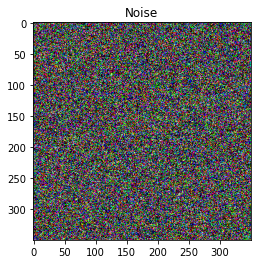

In [24]:
noise = np.random.standard_normal(size=(350,350,3))
plt.figure(1)
plt.title('Noise')
plt.imshow(noise, vmax=1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


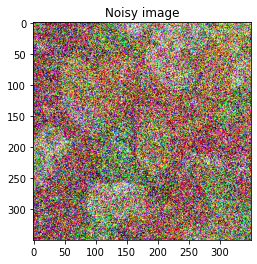

In [26]:
bear_noisy = add_noise(bear_input)
plt.figure(2)
plt.title('Noisy image')
plt.imshow(bear_noisy, vmax=1.0)

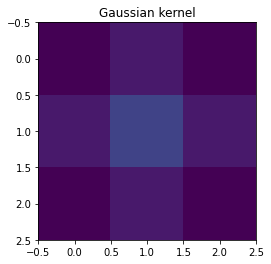

In [28]:
GAUSSIAN_KERNEL = 1/16*np.array([1,2,1,2,4,2,1,2,1]).reshape([3,3])

plt.figure(3)
plt.title('Gaussian kernel')
plt.imshow(GAUSSIAN_KERNEL, vmax=1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


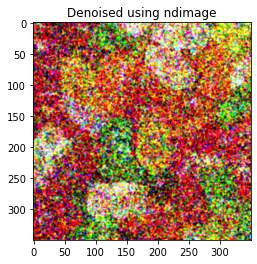

In [29]:
bear_denoised = nd.filters.gaussian_filter(bear_noisy, sigma=(1,1, 0))

plt.figure(4)
plt.title('Denoised using ndimage')
plt.imshow(bear_denoised, vmax=1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


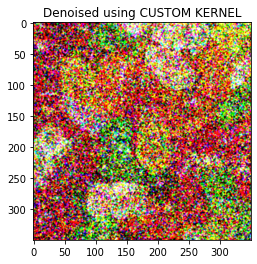

In [31]:
bear_denoised_separated = np.zeros(bear_input.shape)

for i in range(3):
    bear_denoised_separated[:, :, i] = nd.convolve(bear_noisy[:, :, i], GAUSSIAN_KERNEL, mode='constant')

plt.figure(5)
plt.title('Denoised using CUSTOM KERNEL')
plt.imshow(bear_denoised_separated, vmax=1.0)

# Basic Pytorch

In [33]:
gaussian_tensor = torch.tensor(GAUSSIAN_KERNEL, dtype=torch.float32)

In [37]:
gaussian_tensor.size()

torch.Size([3, 3])

In [39]:
input_tensor = torch.tensor(bear_input, dtype=torch.float32)

In [49]:
input_tensor.size()

torch.Size([350, 350, 3])

In [48]:
def torch_preprocess(img: np.ndarray)->torch.Tensor:
    return torch.tensor(img, dtype=torch.float32).permute(dims=[2,0,1]).unsqueeze(dim=0)


In [89]:
def torch_postprocess(tensor: torch.Tensor)->np.ndarray:
    return torch.squeeze(tensor, dim=0).permute(dims=[1,2,0]).numpy()

In [50]:
torch_preprocess(bear_noisy).size()

torch.Size([1, 3, 350, 350])

In [92]:
def denoise_torch(img: np.ndarray, kernel: np.ndarray)->np.ndarray:
    input_tensor = torch_preprocess(img)
    gaussian_tensor = torch.tensor(GAUSSIAN_KERNEL.reshape([1,1,3,3]), dtype=torch.float32)

    #r, g, b = input_tensor[:, 0, :, :], input_tensor[:, 1, :, :], input_tensor[:, 2, :, :]
    r, g, b  = torch.split(input_tensor, split_size_or_sections=[1,1,1], dim=1)

    r_out = F.conv2d(r, gaussian_tensor, padding=1)
    g_out = F.conv2d(g, gaussian_tensor, padding=1)
    b_out = F.conv2d(b, gaussian_tensor, padding=1)

    out = torch.cat([r_out, g_out, b_out], dim=1)
    im_out = torch_postprocess(out)
    return im_out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


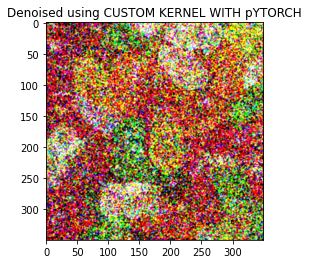

In [93]:
denoised_bear_torch = denoise_torch(bear_noisy, GAUSSIAN_KERNEL)

plt.figure(7)
plt.title('Denoised using CUSTOM KERNEL WITH pYTORCH')
plt.imshow(bear_denoised_separated, vmax=1.0)

In [98]:
class GaussianConvolutionalLayer(torch.nn.Module):
    def __init__(self, gaussian_kernel: np.ndarray):
        super(GaussianConvolutionalLayer, self).__init__()
        self.gaussian_tensor = torch.tensor(gaussian_kernel.reshape([1,1,3,3]), dtype=torch.float32)
    
    def forward(self, x):
        r, g, b  = torch.split(x, split_size_or_sections=[1,1,1], dim=1)

        r_out = F.conv2d(r, self.gaussian_tensor, padding=1)
        g_out = F.conv2d(g, self.gaussian_tensor, padding=1)
        b_out = F.conv2d(b, self.gaussian_tensor, padding=1)

        out = torch.cat([r_out, g_out, b_out], dim=1)

        return out



In [99]:

def denoise_torch_module(img: np.ndarray, kernel: np.ndarray)->np.ndarray:
    input_tensor = torch_preprocess(img)
    gconv = GaussianConvolutionalLayer(kernel)

    out = gconv(input_tensor)

    im_out = torch_postprocess(out)
    return im_out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


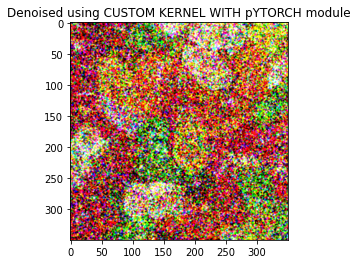

In [100]:
denoised_bear_torch_module = denoise_torch_module(bear_noisy, GAUSSIAN_KERNEL)

plt.figure(9)
plt.title('Denoised using CUSTOM KERNEL WITH pYTORCH module')
plt.imshow(denoised_bear_torch_module, vmax=1.0)